In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 

# custom functions
from helper_functions import extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs

# Data import

In [2]:
df = pd.read_csv("pheno_terpenoids.tsv",sep="\t",index_col=0)

## get the X and y arrays

In [3]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]

# Random Forest analysis 

## Extract feature importance from the RF runs

In [4]:
# generates a list with two elements
# first element average feature importance
# and second element standard deviation
feature_importances = extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nb_of_runs=5,
    njobs=2
)

In [5]:
# determine the average en std deviations 
mean_varimportance = feature_importances[0].mean(axis=1)

# sum the variances (=squared std) and then take the mean
pooled_std = np.sqrt((feature_importances[1]**2).mean(axis=1))

# create panda for convenience
yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

In [6]:
# plot the variable importances for each run and compare them to each other -> gives idea of stability 
#sns.pairplot(data=feature_importances[0])

## Permutations to extract p-values for each feature importance

In [7]:
from helper_functions import extract_feature_importances_from_random_forests_on_permuted_y

# compute feature importances based on permuted y values
feature_importance_perm = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=100,
    njobs=3
)

## Calculate p-values

**How?** By comparing the average feature importance from the original dataset to the distribution of feature importance based on N permutations.   

In [8]:
from helper_functions import get_significant_features

all_pvalues = get_significant_features(X,
                                  original_feature_importances=feature_importances,
                                  permuted_feature_importances=feature_importance_perm,
                                  pval=0.05)
all_pvalues.head()

,p-value,average,sd,rsd
5.541_67.0557,0.0574713,0.004201,0.001203,0.286328
7.060_95.0168,0.413793,0.002420,0.001424,0.588276
9.272_93.0728,0.344828,0.003766,0.002145,0.569687
9.472_91.0566,0.241379,0.003392,0.001825,0.537992
9.653_91.0565,0.264368,0.045564,0.008816,0.193498


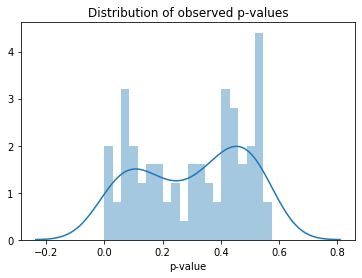

In [9]:
sns.distplot(all_pvalues.iloc[:,0].astype('float'),20)
plt.title('Distribution of observed p-values');

## Write final results to file

In [14]:
# Select significant variables
signif = all_pvalues.loc[all_pvalues.iloc[:,0]<0.05,:].sort_values('p-value')

# write to table
signif.to_csv("Table.volatiles_and_thrips.tsv",sep="\t")

# Plots (heatmap and sum by class)

## Heatmap
To display a heatmap that shows the rows of the non-toxic genotypes followed by the rows of the toxic genotypes.

In [15]:
df_sorted = df.sort_values(by=["wf"])

# make a new column containing the accession and phenotypic class
df_sorted["genotypes and class"] = df_sorted.index.values + "_" + df_sorted["wf"]
df_sorted = df_sorted.set_index(df_sorted["genotypes and class"])

In [20]:
# X matrix similar to the one used for the Random Forest analysis (rows are reordered, not columns)
X = df_sorted.iloc[:,2:]

# add one for log offset
X_disp = X.replace(0,1) 

# Only keep significant variables
X_filt = X_disp.loc[:,signif.index.values]

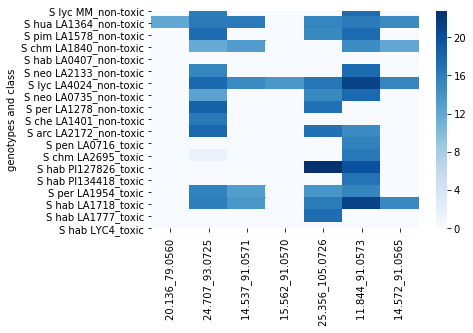

In [21]:
# display heatmap of log2(values)
log_function = lambda x: np.log2(x)
sns.heatmap(X_filt.apply(log_function),cmap="Blues")

## Make plots for each candidate summing over the class

In [22]:
# insert a column with the genotype + class
X_filt.insert(loc=0,column="id",value=X_filt.index.values)

In [23]:
# new data frame with split value columns 
new = X_filt["id"].str.split("_", n = 1, expand = True) 
  
# making separate last name column from new data frame 
X_filt.loc[:,"wf"]= new[1]

# add index column
X_filt = X_filt.set_index("id")

In [24]:
toxic = X_filt.iloc[:,0:-1][X_filt["wf"] == "toxic"].sum()

In [25]:
nontoxic = X_filt.iloc[:,0:-1][X_filt["wf"] == "non-toxic"].sum()

In [26]:
# prepare a dataframe for plotting
sumByClass = pd.DataFrame({'toxic':toxic, 'non-toxic':nontoxic})
sumByClass = sumByClass.reset_index()
sumByClass.columns.values[0]="candidate"
sumByClass = sumByClass.melt(id_vars="candidate",var_name="class",value_name="value")

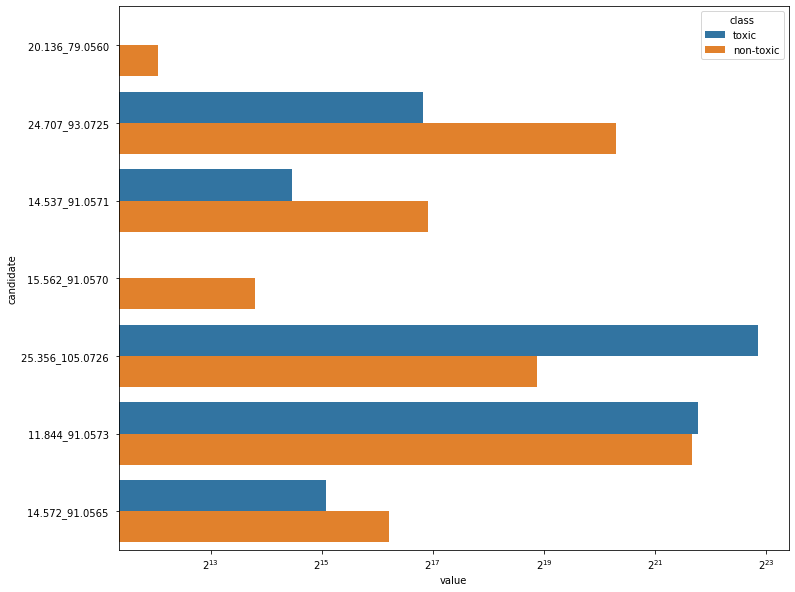

In [27]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_xscale("log",basex=2)
sns.barplot(x="value",y="candidate",hue="class",data=sumByClass,ax=ax)

In [ ]:
sumByClass

# Step-wise selection

This analysis is different because we will use a filtered dataset based on the results using the original, non-filtered dataset.

Significant volatiles that are only detected in the whitefly *non-toxic* class are taken out from the original dataset. That is, their abundance in the *toxic* class should be equal to 0 (not detected in the toxic genotypes).

Indeed, these volatiles are too discriminant between the two classes and thus these volatiles get a very high feature importance. As the goal of this analysis is also to get significant volatiles that are either present in both classes (but quantitatively different) or only detectable in the *toxic* class. 

**Which of the candidate have a value of 0 in the toxic class but a value > 0 in the non-toxic class?**

In [ ]:
candidates_to_drop = sumByClass[(sumByClass["class"] == "toxic") & (sumByClass["value"] == 0)]["candidate"].tolist()
candidates_to_drop

In [ ]:
df = pd.read_csv("pheno_terpenoids.tsv",sep="\t",index_col=0)
print(df.shape)
df.head()

In [ ]:
# remove the 3 volatiles with an abundance equal to zero in the toxic class
df = df.drop(columns=candidates_to_drop)
df.shape

## Define modified X and unmodified y arrays

In [ ]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]
X.head()

In [ ]:
from helper_functions import single_random_forest_run

res = single_random_forest_run(X,y,disp=False,rs=1234,nb_of_splits=6,nb_of_trees=1000)

In [ ]:
res[2]

In [ ]:
dfy = pd.DataFrame(y,columns=['tox'])

In [ ]:
dfy